In [1]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings("ignore")

import sys

sys.path.append("..")

from dataclasses import dataclass
from typing import List, Optional, Any, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, ExtraTreesRegressor
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import MiniBatchKMeans
from tqdm.auto import tqdm

from utils.metrics import Std, DataLoss, StdDataLossTradeoff, StdMeanTradeoff, MDE
from utils.dataset import ModelData
from utils.outliers import QuantileTailClipper
from utils.interpretation import (
    etrp_importance,
    feature_importance_plot,
    comparison_of_dist_by_group,
)

## Outliers Functions

In [2]:
def gen_data_with_outliers(data_size: int, outliers_percent: float):
    """
    Generate a dataset with a specified percentage of outliers.

    Parameters:
    data_size (int): The total number of data points to generate.
    outliers_percent (float): The percentage of data points that should be outliers.

    Returns:
    pd.DataFrame: A DataFrame containing the generated data with outliers.
    """
    data = np.random.normal(0, 1, int(data_size * (1 - outliers_percent)))
    outliers = np.random.normal(10, 1, int(data_size * outliers_percent))
    return pd.DataFrame({"x": np.concatenate((data, outliers))})


# def mark_outliers(data: pd.DataFrame, target_field: str, outlier_field: str) -> pd.DataFrame:
#     """
#     Mark outliers in the DataFrame based on the target field and outlier field.

#     Parameters:
#     data (pd.DataFrame): The input DataFrame containing the data.
#     target_field (str): The name of the column to consider for outlier detection.
#     outlier_field (str): The name of the column that indicates the presence of outliers.

#     Returns:
#     pd.DataFrame: A new DataFrame with outliers marked as 1 if above the median and -1 if below the median.
#     """
#     median = data[target_field].median()
#     zero_data = data[data[outlier_field] == 1]
#     zero_data[outlier_field] = 0

#     outlier_data = data[data[outlier_field] == -1]
#     outlier_data[outlier_field] = outlier_data.apply(
#         lambda x: 1 if x[target_field] > median else -1, axis=1
#     )
#     return pd.concat([zero_data, outlier_data])


def outliers_plot_1d(
    data: pd.DataFrame,
    target_field: str,
    outlier_field: str,
    step=0.001,
    figsize=(15, 10),
):
    """
    Plot a 1-dimensional representation of data with outliers, colored by the outlier_field.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    target_field (str): The name of the field to analyze for outliers.
    outlier_field (str): The name of the field that indicates the presence of outliers.
    step (float): The step size for calculating quantiles. Default is 0.001.
    figsize (tuple): The size of the figure to plot. Default is (15, 10).

    The function creates a line plot where each point represents a quantile of the target_field.
    Points are colored based on the mode of the outlier_field for the range of data that falls
    between the quantiles defined by the step size.
    """
    plt.figure(figsize=figsize)
    c_map = {
        -1: "red",
        1: "black",
    }
    t_data = pd.DataFrame(
        {
            "x": np.arange(step, 1 + step, step),
        }
    )
    t_data["q"] = t_data["x"].apply(lambda x: np.quantile(data[target_field], x))
    t_data["color"] = t_data["x"].apply(
        lambda x: data.loc[
            (
                (data[target_field] > data[target_field].quantile(x - step))
                & (data[target_field] <= data[target_field].quantile(x))
            ),
            outlier_field,
        ].mode()
    )

    display(t_data)

    t_data["color"] = t_data["color"].apply(
        lambda x: (
            c_map.get(x) if isinstance(x, float) else (x[0] if len(x) > 0 else None)
        )
    )

    t_data = t_data.bfill()
    display(t_data)

    plt.scatter(
        t_data["x"],
        t_data["q"],
        c=t_data["color"],
        marker="s",
    )
    plt.title(f"Quantile {target_field} with colors based on {outlier_field}")
    plt.xlabel("Quantile")
    plt.ylabel("Value")
    plt.grid()
    plt.show()


@dataclass
class DefaultModelForComparison:
    """
    Data class to store the default configuration of a model for comparison.

    Attributes:
        model_class: The class of the model.
        default_kwargs: Default keyword arguments for the model.
        tested_parameter_name: The name of the parameter to be tested.
    """

    model_class: type
    default_kwargs: dict[str, Any]
    tested_parameter_name: str

    def create_model(self, tested_parameter_value: Any) -> Any:
        """
        Creates an instance of the model with the tested parameter value.

        Args:
            tested_parameter_value: The value of the parameter to be tested.

        Returns:
            An instance of the model with the specified parameter value.
        """
        return self.model_class(
            **self.default_kwargs,
            **{self.tested_parameter_name: tested_parameter_value},
        )


def outliers_algorithm_testing(data: ModelData, model) -> None:
    """
    Tests an outlier detection algorithm on the given data and model.

    Args:
        data: The data to be used for testing.
        model: The model to be used for outlier detection.
    """
    key = model.__class__.__name__
    data.data[key] = model.fit_predict(
        data.get_data("train", "features").values.reshape(-1, 1)
    )
    # data.data = mark_outliers(data.data, data.features[0], key)
    display(data.data[key].value_counts(normalize=True))
    outliers_plot_1d(data.data, data.features[0], key)


def calc_dot_for_comparison(data: ModelData, model) -> Tuple[float, float, float]:
    """
    Calculates the standard deviation reduction for a given model and data.

    Args:
        data: The data to be used for comparison.
        model: The model to be used for comparison.

    Returns:
        A tuple containing the original standard deviation, new standard deviation, and standard deviation reduction.
    """
    x = data.features[0]
    data.data["dot"] = model.fit_predict(
        data.get_data("train", "features").values.reshape(-1, 1)
    )
    metrics = [StdDataLossTradeoff("x", "dot", "filter", 7).calc(data.data), StdMeanTradeoff("x", "dot", "filter").calc(data.data), MDE("x", "dot", "filter", "group").calc(data.data)]
    return pd.concat(metrics).drop_duplicates()


def models_comparison(
    data: ModelData,
    models: List[DefaultModelForComparison],
    tested_parameter_values: List,
) -> pd.DataFrame:
    """
    Compares multiple models with different parameter values.

    Args:
        data: The data to be used for comparison.
        models: A list of models to be compared.
        tested_parameter_values: A list of parameter values to be tested.

    Returns:
        A DataFrame containing the results of the comparison.
    """
    result_table_list = []
    for v in tqdm(tested_parameter_values):
        for model in models:
            m = model.create_model(v)
            metrics = calc_dot_for_comparison(data, m)
            
            result_table_list += [
                {
                    "model": model.model_class.__name__,
                    "tested_parameter_value": v,
                    "relative_std_diff": metrics.loc["Std", "relative_diff"],
                    "relative_mean_diff": metrics.loc["Mean", "relative_diff"],
                    "std_data_loss_tradeoff": metrics.loc["StdDataLossTradeoff", "metric"],
                    "std_mean_tradeoff": metrics.loc["StdMeanTradeoff", "metric"],
                    "relative_mde_diff": metrics.loc["MDE", "relative_diff"],
                }
            ]
    return pd.DataFrame(result_table_list)


def show_models_comparison_resaults(result_table: pd.DataFrame) -> None:
    """
    Displays the results of the models comparison.

    Args:
        result_table: A DataFrame containing the results of the comparison.
    """
    data_groups = dict(list(result_table.groupby("model")))
    sorted_data_groups = dict(sorted(data_groups.items()))
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    for key, value in sorted_data_groups.items():
        sv = value.sort_values(by=["tested_parameter_value"])
        axs[0].plot(
            sv["tested_parameter_value"],
            sv["relative_std_diff"],
            label=f"{key} relative_std_diff",
            linestyle="dashed",
        )
        axs[0].plot(
            sv["tested_parameter_value"],
            sv["std_data_loss_tradeoff"],
            label=f"{key} std_data_loss_tradeoff",
        )
        axs[0].plot(
            sv["tested_parameter_value"],
            sv["relative_mde_diff"],
            label=f"{key} relative_mde_diff",
            linestyle="dotted",
        )
        axs[1].plot(
            sv["tested_parameter_value"],
            sv["relative_mean_diff"],
            label=f"{key} relative_mean_diff",
            linestyle="dashed",
        )
        axs[1].plot(
            sv["tested_parameter_value"],
            sv["std_mean_tradeoff"],
            label=f"{key} std_mean_tradeoff",
        )
    plt.legend()
    plt.grid()
    plt.show()

## Gen data

,x,group
0,-0.389789,1
1,-0.522036,1
2,-2.663767,1
3,-0.728979,0
4,-1.219326,1
...,...,...
1019995,0.000000,1
1019996,0.000000,0
1019997,0.000000,1
1019998,0.000000,0


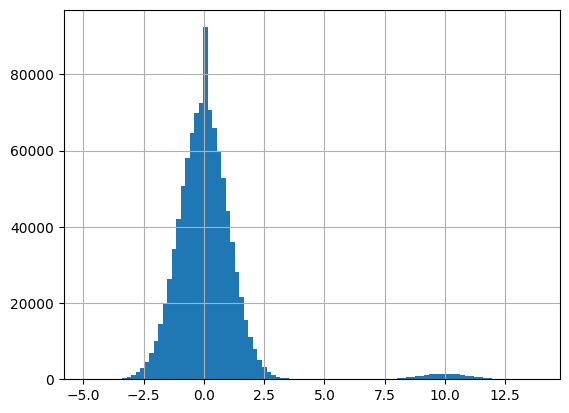

In [3]:
gen_data = gen_data_with_outliers(1_000_000, 0.02)
gen_data = pd.concat(
    [gen_data, pd.DataFrame({"x": [0] * 20_000})], axis=0, ignore_index=True
)
gen_data["x"].hist(bins=100)
data = ModelData(gen_data, ["x"])
data.split_data(0.5)
data.data["group"] = data.data.index.isin(data.index_sets["train"]) * 1
data.index_sets = ModelData.default_index_set(data.data)
data

In [5]:
Std("x", "group", "strat").calc(data.data).iloc[0]["metric"]

1.7034258349696467

# Quantile Tail Clipper 

In [4]:
model = QuantileTailClipper(contamination=0.01)
data.data[model.__class__.__name__] = model.fit_predict(
    data.get_data("train", "features").values.reshape(-1, 1)
)
data

,x,group,QuantileTailClipper
0,-1.146971,1,1
1,-1.737163,0,1
2,-1.542712,0,1
3,-0.260955,1,1
4,-0.200865,0,1
...,...,...,...
1019995,0.000000,0,1
1019996,0.000000,1,1
1019997,0.000000,0,1
1019998,0.000000,1,1


In [6]:
calc_dot_for_comparison(data, model).round(3)

,metric,filtered,diff,relative_diff,control_size,test_size,var_control,var_test
Std,1.704,1.336,0.368,0.216,NaN,NaN,NaN,NaN
DataLoss,1020000.000,1009800.000,10200.000,0.010,NaN,NaN,NaN,NaN
StdDataLossTradeoff,0.201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mean,0.195,0.088,0.107,0.550,NaN,NaN,NaN,NaN
StdMeanTradeoff,0.097,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MDE,0.009,0.007,0.002,0.212,510000.0,510000.0,2.886,2.923


## Eleptic Envelope

EllipticEnvelope
 1    0.99
-1    0.01
Name: proportion, dtype: float64

,x,q,color
0,0.001,-3.076430,1.0
1,0.002,-2.870473,1.0
2,0.003,-2.735746,1.0
3,0.004,-2.639213,1.0
4,0.005,-2.566036,1.0
...,...,...,...
995,0.996,10.836554,-1.0
996,0.997,11.024090,-1.0
997,0.998,11.266543,-1.0
998,0.999,11.634086,-1.0


,x,q,color
0,0.001,-3.076430,black
1,0.002,-2.870473,black
2,0.003,-2.735746,black
3,0.004,-2.639213,black
4,0.005,-2.566036,black
...,...,...,...
995,0.996,10.836554,red
996,0.997,11.024090,red
997,0.998,11.266543,red
998,0.999,11.634086,red


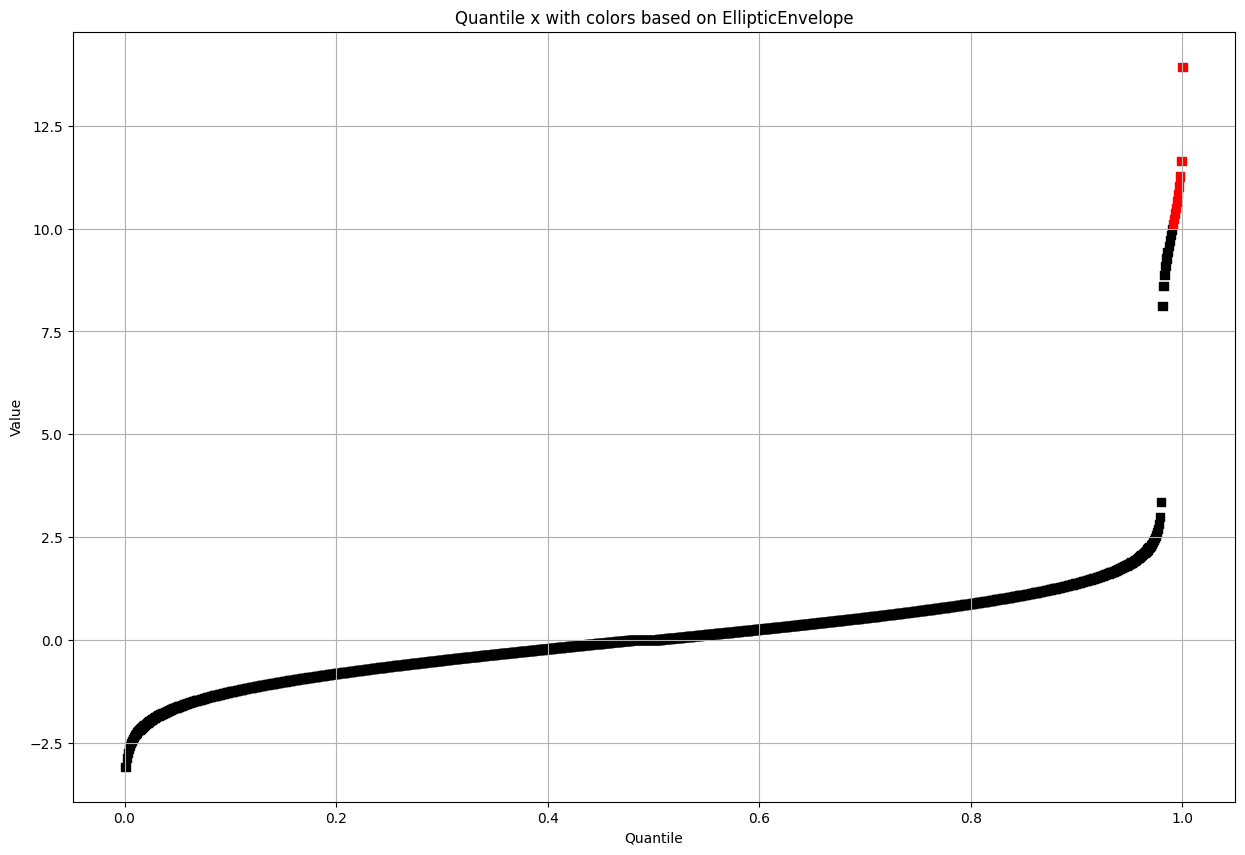

In [6]:
model = EllipticEnvelope(contamination=0.01)
outliers_algorithm_testing(data, model)

## Isolation Forest

IsolationForest
 1    0.990016
-1    0.009984
Name: proportion, dtype: float64

,x,q,color
0,0.001,-3.076430,1.0
1,0.002,-2.870473,1.0
2,0.003,-2.735746,1.0
3,0.004,-2.639213,1.0
4,0.005,-2.566036,1.0
...,...,...,...
995,0.996,10.836554,-1.0
996,0.997,11.024090,-1.0
997,0.998,11.266543,-1.0
998,0.999,11.634086,-1.0


,x,q,color
0,0.001,-3.076430,black
1,0.002,-2.870473,black
2,0.003,-2.735746,black
3,0.004,-2.639213,black
4,0.005,-2.566036,black
...,...,...,...
995,0.996,10.836554,red
996,0.997,11.024090,red
997,0.998,11.266543,red
998,0.999,11.634086,red


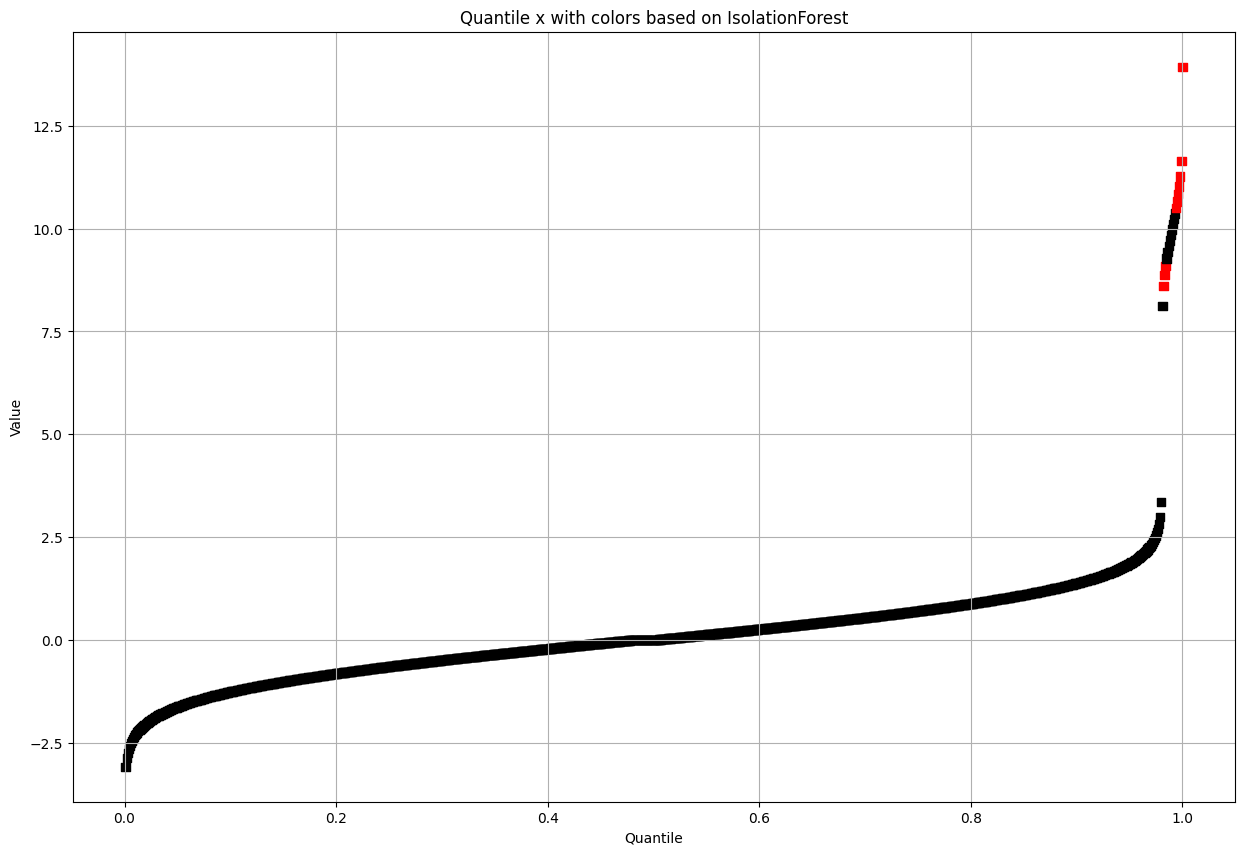

In [7]:
model = IsolationForest(n_jobs=-1, n_estimators=1000, contamination=0.01)
outliers_algorithm_testing(data, model)

## Compare Algorithms

  0%|          | 0/9 [00:00<?, ?it/s]

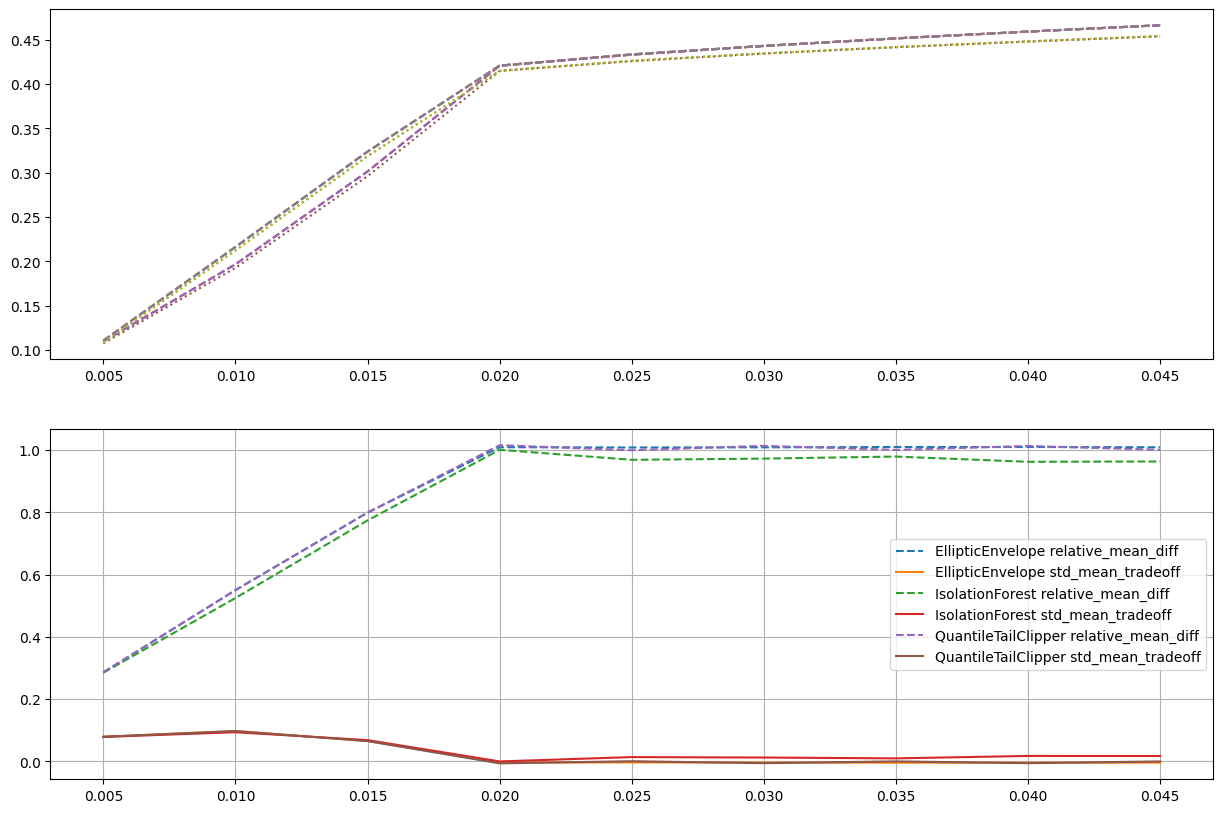

In [7]:
default_models = [
    DefaultModelForComparison(
        IsolationForest, {"n_estimators": 1000, "n_jobs": -1}, "contamination"
    ),
    DefaultModelForComparison(EllipticEnvelope, {}, "contamination"),
    # DefaultModelForComparison(LocalOutlierFactor, {'n_neighbors': 20}, 'contamination'),
    DefaultModelForComparison(QuantileTailClipper, {}, "contamination"),
]
comparison_table = models_comparison(
    data, default_models, np.arange(0.005, 0.055, 0.005)
)
show_models_comparison_resaults(comparison_table)

In [1]:
comparison_table = comparison_table.sort_values(
    "std_mean_tradeoff", ascending=False
)
comparison_table

NameError: name 'comparison_table' is not defined

In [ ]:
comparison_table.to_csv("outlier_filter_comparison_table.csv", index=False)

# Permutation Importance

In [3]:
data = ModelData.load_california_housing_data()
data.split_data(test_size=0.2)
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [4]:
importances = etrp_importance(data)
importances

  0%|          | 0/8 [00:00<?, ?it/s]

,importances mean,importances std
MedInc,0.752965,0.013573
Latitude,0.383304,0.007064
Longitude,0.323255,0.006168
AveOccup,0.163549,0.006363
HouseAge,0.077352,0.004374
AveRooms,0.020171,0.000943
AveBedrms,0.008705,0.001082
Population,0.004308,0.000597


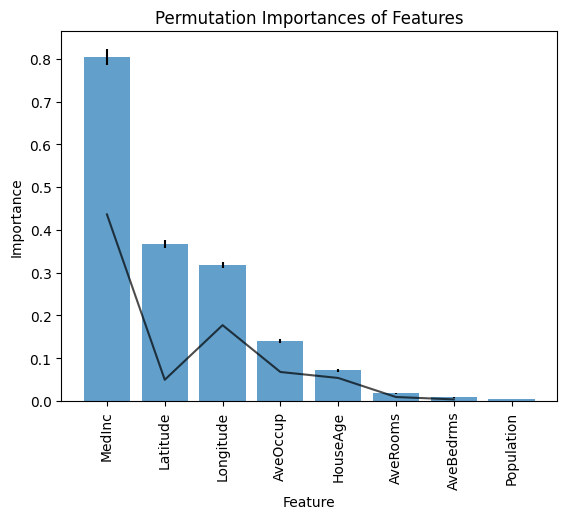

In [ ]:
feature_importance_plot(importances)

# Segmentation

## Mini batch knn

In [2]:
def one_segmentation_experiment(data: ModelData, model):
    data.data["cluster"] = model.fit_predict(data.get_data("all", "features"))
    display(data.data["cluster"].value_counts(normalize=True) * 100)
    data2d = pd.DataFrame(
        UMAP(n_jobs=-1).fit_transform(data.get_data("all", "features")),
        columns=["x", "y"],
    )
    data2d["cluster"] = data.data["cluster"]
    sns.scatterplot(data=data2d, x="x", y="y", hue=data2d["cluster"], palette="viridis")
    data.data["group"] = 1
    d_std = strat_std(data.data, data.target, "group")
    d_sstd = strat_std(data.data, data.target, "group", "cluster")
    plt.show()
    result = {
        "std": d_std.loc["total", "var"],
        "strat std": d_sstd.loc["total", f"{data.target}_strat_var"],
    }
    result["diff"] = 1 - result["strat std"] / result["std"]
    return result


def search_k(data: ModelData, max_k: int, n_iterations=1):
    iter_result = []
    for i in tqdm(range(n_iterations)):
        result_arr = []
        for k in tqdm(range(2, max_k)):
            model = MiniBatchKMeans(n_clusters=k)
            data.data["cluster"] = model.fit_predict(data.get_data("all", "features"))

            metric = Std(data.target, "cluster", "strat").calc(data.data).iloc[0]

            result_arr.append({
                "k": k,
                "std": metric["metric"],
                "strat std": metric["strat"],
                "diff": metric["diff"],
                "relative_diff": metric["relative_diff"],
            })
        ir = pd.DataFrame(result_arr)
        ir["iter"] = i
        iter_result.append(ir)
    return pd.concat(iter_result, axis=0)

In [3]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler

In [4]:
# import pandas as pd

# # Download the dataset
# url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv'
# df = pd.read_csv(url)

# data = ModelData(df, features=df.drop(columns=["tip"]).columns, target="tip")
# data.split_data(test_size=0.2)
# encoder = data.encode_categoricals(encoder=TargetEncoder(), y = data.get_data("all", "target"))
# scaler = data.scale_features(scaler=StandardScaler())
# data

In [13]:
data = ModelData.load_california_housing_data()
scaler = data.scale_features(scaler=StandardScaler())
data.split_data(test_size=0.2)
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835,2.129631
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844,1.314156
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827,1.258693
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818,1.165100
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818,1.172900
...,...,...,...,...,...,...,...,...,...
20635,-1.216128,-0.289187,-0.155023,0.077354,-0.512592,-0.049110,1.801647,-0.758826,-1.115804
20636,-0.691593,-0.845393,0.276881,0.462365,-0.944405,0.005021,1.806329,-0.818722,-1.124470
20637,-1.142593,-0.924851,-0.090318,0.049414,-0.369537,-0.071735,1.778237,-0.823713,-0.992746
20638,-1.054583,-0.845393,-0.040211,0.158778,-0.604429,-0.091225,1.778237,-0.873626,-1.058608


In [14]:
Std(data.target, "HouseAge", "strat").calc(data.data)

,mean,var,size,strat,metric,diff,relative_diff
HouseAge,,,,,,,
-2.196180,-0.542112,0.305565,4,0.985503,1.000024,0.014522,0.014521
-2.116722,0.152697,0.984919,58,0.985503,1.000024,0.014522,0.014521
-2.037264,0.249476,0.832740,62,0.985503,1.000024,0.014522,0.014521
-1.957806,0.193940,0.788251,191,0.985503,1.000024,0.014522,0.014521
-1.878348,0.013535,0.856948,244,0.985503,1.000024,0.014522,0.014521
-1.798890,-0.026530,0.793457,160,0.985503,1.000024,0.014522,0.014521
-1.719432,-0.117510,0.745633,175,0.985503,1.000024,0.014522,0.014521
-1.639974,-0.107816,0.785788,206,0.985503,1.000024,0.014522,0.014521
-1.560516,-0.174908,0.725722,205,0.985503,1.000024,0.014522,0.014521


In [15]:
# mini_batch_kmeans = MiniBatchKMeans(n_clusters=10)
# one_segmentation_experiment(data=data, model=mini_batch_kmeans)

In [16]:
k_scores = search_k(data=data, max_k=200, n_iterations=5)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

<Axes: xlabel='k'>

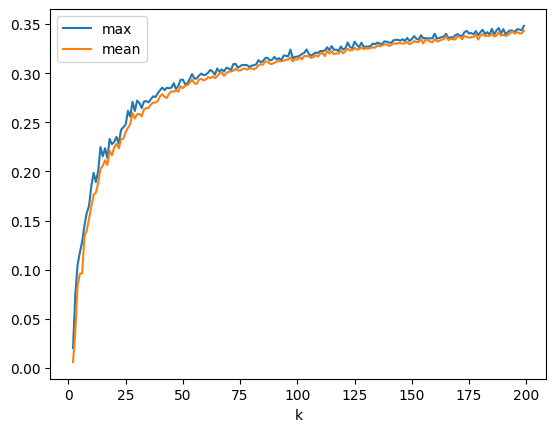

In [17]:
k_scores.groupby("k")["relative_diff"].agg(["max", "mean"]).plot()